# PC lab 3: Intro to NLP via word2vec and character-level language modeling

# 1 Word2Vec

## 1.1 Introduction

Word2vec is a famous technique for obtaining dense representations of words that carry some notion of their semantic meaning. The usual way of representing a word as part of a vocabulary is by one-hot encoding. For example, embedding the word "Royal" in a vocabulary of 10.000 possible words would result in a 10.000 dimensional vector filled with zeros with only one nonzero element in the index corresponding to the word "Royal". **One-hot encoding has some adverse effects on learning:** (1) it is a sparse representation. When we embed a 10.000 dimensionality vector to a lower dimensionality (e.g. 512) with a matrix multiplication using learned weights $W$, only one row of $W$ will learn weights pertaining to a specific word (because the input will be zeros at the indices for other words). This is visualized in the figure below. (2) Secondly, one-hot encodings carry no semantic meaning at all for words that are similar. All words are orthogonal. The representation for "run" and "runs" has no similarity and the meaning of **every** word (and in essence the meaning of the whole language) has to be learned from scratch for every NLP task using one-hot encoding. In many supervised problems with limited data, this is usually not possible.

<img src="https://i0.wp.com/www.hackdeploy.com/wp-content/uploads/2019/11/eb6ffd3d-03fe-4cc9-a88f-fef1996b448d.jpg?fit=600%2C345&ssl=1" width = 400>

One way around these facts is to try to **pre-train** a word representation that is (1) dense and (2) carries similarity between words. Of course, to do this, we need (1) a **large training dataset** of natural language and (2) a model **objective**.

Word2vec is considered a breakthrough in deep learning/NLP because it offered a ridiculously simple solution: predicting the neighboring words from an input word in a sentence. For example, in the sentence: "I like dogs but not cats", we would (at random) sample as input word "dogs" and at random sample an output word "like", and then try to predict the word "like" from the word "dogs".
Architecturally it looks like the image below: we one-hot encode both words, send the input word through a hidden layer which is then the embedding for that word, and try to predict the output word as a multi-class classification of all possible words:

<img src="http://mbenhaddou.com/wp-content/uploads/2019/12/img_4.png" width = 250>

The rationale of the technique is that the meaning of a word can be derived from the contexts in which it is used. Similar words will be used in similar contexts (E.g. the words "cats" and "dogs" are used in similar contexts such as "i like dogs" and "i like cats" or "i have a dog" and "i have a cat".) The ingenius of this technique is that it can easily be scaled up because we don't need a labeled dataset: any possible text can be used, and there's a practically infinite amount of available text on the internet.

The first layer of the resulting model is our embedding layer: it embeds every possible word in a lower-dimensional subspace in which word similarities are preserved. When people start a NLP problem, it is most useful to use this representation as opposed to a one-hot encoding, because we don't need to learn the meaning of every word from scratch anymore.

We will give a primer on how to use word embeddings in this PC lab using the `gensim` library.

## 1.2 Gensim library

In this PC lab, we're going to use the pre-trained word2vec model published by google. It embeds every word in a 300-dimensional subspace.

Downloading the model: the following code only works on google colab.
It is quite a large file, Google Colab download speeds are excellent because it does not have to download to the own system.

If you're running this locally, use:
```
import gensim.downloader as api
w2v = api.load("word2vec-google-news-300") 
```
Keep in mind that downloading this model may take a **very** long time.

Also, keep in mind that loading in this model takes up **a lot** of RAM memory.


Last note: if you download gensim locally, there is a good chance you will be using gensim 4.0, while the google colab environment is still on gensim 3.6. A lot of functionality has changed place inbetween these version. Keep in mind that this notebook has been written with gensim 3.6 in mind.

In [ ]:
!gdown https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
!gunzip GoogleNews-vectors-negative300.bin.gz

from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:13<00:00, 119MB/s]
gzip: GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? n
	not overwritten


The model can be called like a dictionary:

In [ ]:
vector = w2v['dogs']
print(vector)
print(vector.shape)

[-0.02050781 -0.01245117 -0.12792969  0.21777344 -0.140625    0.02612305
  0.04443359  0.03710938 -0.14160156  0.03466797  0.23925781 -0.50390625
  0.02636719 -0.03442383 -0.02990723  0.12988281 -0.16699219  0.20703125
 -0.28710938  0.05493164  0.16992188 -0.15917969  0.09472656 -0.22070312
 -0.1953125   0.11474609 -0.24511719  0.23535156  0.10009766 -0.0703125
 -0.21972656  0.00309753 -0.01483154 -0.12402344 -0.012146    0.04907227
 -0.24511719 -0.00245667  0.05761719  0.27148438  0.07958984 -0.15917969
 -0.0234375  -0.0111084  -0.06396484 -0.15722656  0.24804688  0.0279541
 -0.08642578  0.09619141  0.08935547  0.05322266  0.26757812  0.06542969
  0.14453125 -0.0612793   0.24414062 -0.16113281  0.10644531  0.03662109
  0.12255859  0.12402344  0.26953125  0.07177734  0.05151367 -0.10644531
  0.11083984  0.03149414 -0.25585938  0.08203125  0.2734375   0.05957031
 -0.17773438  0.13671875 -0.03833008 -0.12597656  0.10742188 -0.16601562
  0.09619141 -0.16601562 -0.06494141 -0.14355469  0.2

Some words may not occur in the vocabulary:

In [ ]:
w2v["modelling"]

KeyError: ignored

"modelling" is the british english spelling of the word, whereas this model has (apparently) exclusively been trained on american english text, always using "modeling".

The model has an easy-to-use method for trying to find which words are most similar to other words: (using cosine similarity)

In [ ]:
w2v.most_similar("python")

[('pythons', 0.6688377857208252),
 ('Burmese_python', 0.6680365800857544),
 ('snake', 0.6606292724609375),
 ('crocodile', 0.6591362953186035),
 ('boa_constrictor', 0.6443520188331604),
 ('alligator', 0.6421656608581543),
 ('reptile', 0.6387744545936584),
 ('albino_python', 0.6158880591392517),
 ('croc', 0.6083584427833557),
 ('lizard', 0.6013416647911072)]

Note: case-sensitivity matters and the two different versions of the word may occur and different contexts. Hence, it may change the embedding (and meaning) of the words:

In [ ]:
w2v.most_similar("Python")

[('Jython', 0.6152505874633789),
 ('Perl_Python', 0.5710949897766113),
 ('IronPython', 0.5704678893089294),
 ('scripting_languages', 0.5695090889930725),
 ('PHP_Perl', 0.5687724351882935),
 ('Java_Python', 0.568107008934021),
 ('PHP', 0.5660915374755859),
 ('Python_Ruby', 0.5632462501525879),
 ('Visual_Basic', 0.5603480339050293),
 ('Perl', 0.5530890226364136)]

In [ ]:
w2v.most_similar("mango")

[('mangoes', 0.7850891351699829),
 ('mangos', 0.7233096361160278),
 ('guava', 0.7192398905754089),
 ('coconut', 0.6775304079055786),
 ('jackfruit', 0.6722090244293213),
 ('pineapple', 0.6678789854049683),
 ('tamarind', 0.6678106188774109),
 ('citrus_fruit', 0.6667780876159668),
 ('fruit', 0.6631807088851929),
 ('cashew', 0.6624342203140259)]

Word2vec is famous for encoding words in a vector space wherein it is possible to do arithmetic.

For example: if we substract "man" from "prince" and add "woman", we get "princess":

$E_{prince} - E_{man} = x - E_{woman}$

$x \simeq E_{princess}$

In other words: a prince is to a man as a princess is to a woman.

In [ ]:
w2v.most_similar( positive = ["prince", "woman"], negative = ["man"], topn = 3)

[('princess', 0.704118013381958),
 ('duchess', 0.6229751110076904),
 ('monarch', 0.6019775867462158)]

Some other examples:

In [ ]:
w2v.most_similar( positive = ["leg", "shoulder"], negative = ["arm"], topn = 3)

[('knee', 0.6865607500076294),
 ('ankle', 0.6698983907699585),
 ('shin', 0.6183128356933594)]

In [ ]:
w2v.most_similar( positive = ["Paris", "Spain"], negative = ["France"], topn = 3)

[('Madrid', 0.7571903467178345),
 ('Barcelona', 0.6230698823928833),
 ('Seville', 0.5604877471923828)]

However, some analogies are far from fun. Word2vec has been known to carry gender bias in its word embeddings. For example, if we take the embedding for "sewing", substract "woman", and add "man", we get:

In [ ]:
w2v.most_similar( positive = ["man", "sewing"], negative = ["woman"], topn = 3)

[('woodworking', 0.61572265625),
 ('sew', 0.5990197658538818),
 ('knitting', 0.5887658596038818)]

More worrying, if we take the embedding for "computer_programmer" (a high-paying job), substract "man" and add "woman", we get:

In [ ]:
w2v.most_similar( positive = ["woman", "computer_programmer"], negative = ["man"], topn = 3)

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105047225952148),
 ('graphic_designer', 0.505180299282074)]

Lastly, if men are stereotypically conservative, women are:

In [ ]:
w2v.most_similar( positive = ["woman", "conservatism"], negative = ["man"], topn = 3)

[('liberalism', 0.6615055799484253),
 ('feminism', 0.5954433679580688),
 ('conservatives', 0.5825741291046143)]

It's important to keep in mind that the bias here can be interpreted in a multitude of ways. A good video discussing the sources of bias and ways around it (applied on a google translate case) is this one: https://www.youtube.com/watch?v=J7CrtblmMnU.

## 1.3 Data analysis on word embeddings.

As mentioned previously, we can use these word embeddings as pre-trained vectors in various NLP applications. Here, we will explore them for data visualization.

<div class="alert alert-success">

<b>EXERCISE:</b> 
<p> Randomly sample some words (e.g. 1000) from the word2vec corpus. Reduce their dimensionality using t-SNE to 2 dimensions. Cluster the embeddings in this low-dimensionality subspace. Visualize the results. Inspect some clusters. Do they make sense?
</p>

</div>

Use the code below to help you get started:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


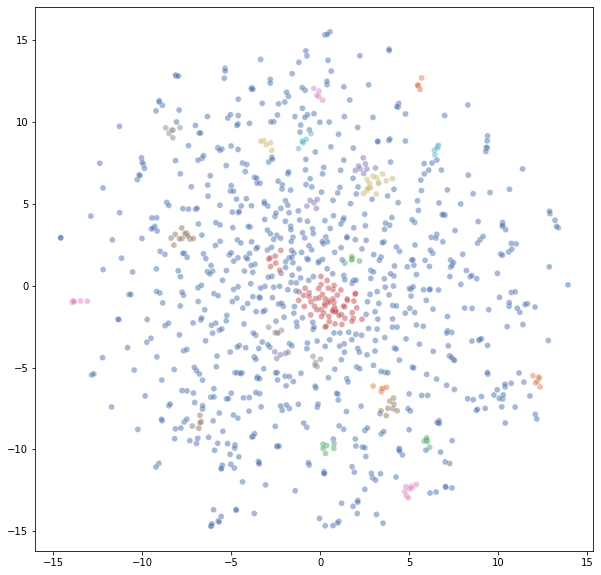

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import # your algorithm here


vocab = w2v.index2entity # all words for which the model has embeddings.

# sample words here

embeddings = # extract embeddings here

data_tsne = TSNE().fit_transform(embeddings)

clustering = # cluster here

cluster_labels = # extract cluster labels here

plt.figure(figsize = (10, 10))
sns.scatterplot(x = data_tsne[:, 0], y = data_tsne[:, 1], alpha = 0.5, hue = cluster_labels, palette="deep", legend = False)

Finally, it is useful to think about how we can use word embeddings in learning.

Let's say we want to classify words as being "fruits". To do so, it is of course necessary to have a list of fruits and embed them using the word2vec model. There are multiple ways to create a "fruit classifier" from the resulting embeddings:

One way is adding some non-fruit words as a negative set, embedding both the fruits and the non-fruits and using any standard machine learning algorithm to train a model.

Another way is to keep in mind that it is perfectly possible to do arithmetic on these vectors. Therefore, it is perfectly reasonable to average the embeddings of fruits into one vector that is then the "meta-fruit" vector. Using this single vector, it is also possible to classify words as being fruits.

# 2 RNNs for language modeling

## 2.1 Introduction

Recurrent networks strictly operate on 1-D sequences. They can be used for a variety of tasks, pictured below:

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width = 500>

Examples of the settings in the picture:
- one to one: vanilla MLPs that map a fixed size 1-D vector to a 1-D vector for classification or regression
- one to many: Image captioning, given an input embedding (obtained with a CNN), a textual caption of variable length is generated.
- many to one: (1) Sentence classification such as sentiment analysis or (2) image generation from text: in both cases variable input texts are given as input and a fixed dimensional output is generated.
- many to many: (1) machine translation of a variable-length sentence to another variable-length sentence or (2) transcription of a variable-length .mp3 audio to a variable length text.
- many to many (1to1 correspondence): (1) Video classification: one label for a variable number of frames in the video (the video frame embedding can be obtained with a CNN and then input into a RNN), (2) autoregressive language modeling: trying to predict the next word in the sentence, for generative purposes or (3) word classification: classify every word as belonging to a category.

Note that these settings are not exclusive to recurrent neural networks. In fact, any network type that works on variable input sequences can be used towards these ends. Most famously of which are of course, Transformers, which have all but replaced RNNs in NLP and many other fields. An explanation and implementation of transformers is out of the scope of this course. It suffices to know that RNNs process input sequence sequentially through memory cells, whereas transformers do it in parallel through an $n \times n$ attention matrix. Other than RNNs and Transformers, convolutional networks can also be used on variable length inputs: a 1D kernel can equally well convolve over a sequence of length $100$ as $1000$. It is only because of the linear layers at the end for classification requiring a specific number of input nodes that typical CNNs become applicable on only one specific input size.

Recurrent neural networks are often one layer deep, as opposed to modern convnets reaching hundreds of layers. However, it is unfair to compare both types of architectures in this way. If an RNN takes in an input sequence of length 100, by the time the information in the first element reaches the last, it will have gone through a hundred hidden memory cells, each with its activation functions and (shared weights) linear layers. Hence, you could say that this element would have gone through a neural network 100 layers deep. In this sense, the depth of RNNs scales dynamically with input sequence length.

## 2.2 Character level autoregressive language modeling

Autoregressive language modeling is the task of trying to predict the next word or character in a sentence given which words or characters came before it: $P(x_i | x_{i-1}, x_{i-2}, ..., x_1)$.

In this PC-lab we will explore language modeling on the char level as opposed to the word level. A few considerations in this regard:

The biggest advantage is that it has less classes ($N_{words} >>> N_{chars}$), hence resulting in a classification task that is easier to optimize, and generally needing less data. The disadvantage is that the model will not learn to predict words itself and has to compose them from scratch, often resulting in gibberish words.

Architecturally, autoregressive language modeling of characters using a vanilla RNN looks like this:

<img src="http://karpathy.github.io/assets/rnn/charseq.jpeg" width = 300>

The model will embed input words to a hidden layer which acts as a memory bank. The memory bank of every input will consist of a combination of the information at that time point and the information coming in from the memory cell at the previous time point. The specific way this information is brought together depends on the specific construction of the RNN. We refer you to the theory lectures for details. The most popular constructions are the LSTM and the GRU memory cells. For every timestep, the model outputs a vector of $n$ dimensions, with $n$ the number of possible characters. We compute the cross entropy for every character on these vectors as a loss function and backpropagate.

Code-wise, it is important to know that for a given sentence, we have an input $x$ consisting of the words in that sentence, and an output $y$, consisting of the same words, but **shifted one time-step to the left**. **Because of the directionality of the RNN, for every time-step, it will predict the next character given only the preceding ones.**


In [ ]:
import torch
import torch.nn as nn
import numpy as np


To train a character LM: We'll use the content of the book "Anna Karenina" by Leo Tolstoy

In [ ]:
!wget https://raw.githubusercontent.com/cdemutiis/LSTM_RNN_Text_generation/master/anna.txt
with open('./anna.txt', 'r') as f:
    text = f.read()

--2022-04-22 12:10:49--  https://raw.githubusercontent.com/cdemutiis/LSTM_RNN_Text_generation/master/anna.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2025486 (1.9M) [text/plain]
Saving to: ‘anna.txt’

anna.txt            100%[===================>]   1.93M  --.-KB/s    in 0.1s    

2022-04-22 12:10:50 (13.3 MB/s) - ‘anna.txt’ saved [2025486/2025486]



Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

In [ ]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [ ]:
import re
text = re.sub('\n', ' ', text)
text[:100]

'Chapter 1   Happy families are all alike; every unhappy family is unhappy in its own way.  Everythin'

In [ ]:
text = re.sub(' +', ' ', text)
text[:100]

'Chapter 1 Happy families are all alike; every unhappy family is unhappy in its own way. Everything w'

In [ ]:
text = text.lower()
text[:100]

'chapter 1 happy families are all alike; every unhappy family is unhappy in its own way. everything w'

Because PyTorch can not interpret string characters directly, we convert our characters to integers, using a dictionary as a vocabulary:

In [ ]:
unique_chars = set(text)
char2int = {v : k for k, v in enumerate(unique_chars)}
int2char = {v : k for k, v in char2int.items()}

In [ ]:
torch.tensor([char2int[l] for l in list(text[:100])])

tensor([18, 22, 12, 31,  4, 32, 42, 13, 34, 13, 22, 12, 31, 31,  2, 13, 35, 12,
        28, 11, 48, 11, 32, 40, 13, 12, 42, 32, 13, 12, 48, 48, 13, 12, 48, 11,
        36, 32, 23, 13, 32, 15, 32, 42,  2, 13,  8, 29, 22, 12, 31, 31,  2, 13,
        35, 12, 28, 11, 48,  2, 13, 11, 40, 13,  8, 29, 22, 12, 31, 31,  2, 13,
        11, 29, 13, 11,  4, 40, 13, 14, 49, 29, 13, 49, 12,  2, 46, 13, 32, 15,
        32, 42,  2,  4, 22, 11, 29, 21, 13, 49])

For training, we can't put the whole book in to our model as one sample. Just like the reason for doing batches in other networks is that: it is more computationally efficient, and it allows us to have training steps on different parts of data with some stochasticity to it, allowing us to jump out of local minima.

For RNN, another reason is that our "actual" neural network depth is essentially decided by our input length, so if we send in a sample containing a million input tokens (chars), we also backpropagate through a million layers, and our computers will surely crash. In addition, it is not reasonable to assume a character a million chars away still influences the prediction of what's the next character in the sequence. So, the problem of batching our text becomes one of weighing two factors: how long of a sequence can our model handle, and how much context (in number of preceding characters) do our models need for prediction?

Here we will take 50 as a default:

In [ ]:
def generate_batches(text, seqlen = 50):
    batches = []
    for i in np.arange(0, len(text) - seqlen, seqlen):
        batches.append(text[i:i+seqlen])
    return torch.stack(batches)

In [ ]:
data = generate_batches(torch.tensor([char2int[l] for l in list(text)]))

In [ ]:
data.shape

torch.Size([39523, 50])

In [ ]:
data[0]

tensor([18, 22, 12, 31,  4, 32, 42, 13, 34, 13, 22, 12, 31, 31,  2, 13, 35, 12,
        28, 11, 48, 11, 32, 40, 13, 12, 42, 32, 13, 12, 48, 48, 13, 12, 48, 11,
        36, 32, 23, 13, 32, 15, 32, 42,  2, 13,  8, 29, 22, 12])

## 2.3 Encoding text

We need to encode our integer 'classes' of characters to a vector for input into the RNN. The most straightforward way of doing so is via one-hot encoding.

In [ ]:
one_hot = nn.functional.one_hot(data, num_classes = len(unique_chars))
print(one_hot[0,:5])
one_hot.shape

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


torch.Size([39523, 50, 56])

An alternative is the `nn.Embedding` layer, which uses a **learnable look up table**. It is learnable because the numbers in the look-up table act as weights and PyTorch is able to compute the gradient of those numbers w.r.t. the loss.

Information-wise, both representations contain the same information: what input token is present at which position. With `nn.Embedding`, the advantage is that the information is already distributed over all input features and makes up a dense representation, which will aid feature learning (all input weights of the first layer will be used optimally), whereas this is not the case for a one hot encoded vocabulary. In addition, `nn.Embedding` allows us to choose an arbitrarily dimensionality for our input tokens.

<img src="https://raw.githubusercontent.com/gdewael/teaching/main/predmod/NLP/onehotvsembedding.png" width = 300>

In [ ]:
t = nn.Embedding(num_embeddings = len(unique_chars), embedding_dim = 8)
embedded = t(data)
print(embedded[0,:5])
embedded.shape

tensor([[ 0.1192, -0.2315, -0.5006,  0.1289,  0.5616,  1.1376, -0.8923, -0.4254],
        [-0.5633, -1.4780,  0.7272, -3.4017, -1.0024,  0.2810,  0.6311, -0.3528],
        [-1.9426,  0.4265,  0.0304,  0.2706,  0.1811, -0.0743,  2.2381, -0.0954],
        [ 0.0126,  0.5426,  0.6950,  0.0784, -0.2414, -0.6622,  0.2045,  1.2554],
        [ 0.5589, -0.8246, -1.4034, -0.8905,  2.2930,  0.5590, -0.7760, -0.1234]],
       grad_fn=<SliceBackward0>)


torch.Size([39523, 50, 8])

## 2.4 GRUs in PyTorch

[Documentation for the GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

Extra note: The weird shape expectations (such as not expecting batches to come first by default) are a consequence of optimizations that PyTorch has implemented so the RNNs run efficiently on data with variable input sequence lengths (such as sentences). For this PC lab, we have batched our sequences so that they have constant sequence length, so we can add the argument `batch_first = True`.

In [ ]:
gru = nn.GRU(input_size = 64, hidden_size = 512, batch_first = True)

In [ ]:
x = torch.randn(2, 50, 64)
output, h_n = gru(x)
output.shape, h_n.shape

(torch.Size([2, 50, 512]), torch.Size([1, 2, 512]))

Explanation of the outputs: `h_n` is the hidden representation of the last hidden memory cell. It can be seen as a summarized representation of the content of the whole input (if one want for example a single output for a whole sequence as in sentence classification). `output` will return the output representation of the RNN for every input token. (Look back at the picture in the introduction of this part of the PC lab (Section 2.1) for more intuition as to when to use what outputs of the RNN)

For character level language modeling, we should have an output for every input, mainly: the prediction of the next word. For this purpose, if we have $n$ number of possible characters (classes), we should also have $n$ number of output nodes at every characters, whereas we can see that this is not the case for our GRU model as it is now.

<div class="alert alert-success">

<b>EXERCISE:</b> 
<p> Implement an autoregressive GRU by completing the code below. The model should contain an embedding layer (or one-hot encoding operation), recurrent layer, and a layer that takes the outputs of the GRU at each timestep and manipulates their dimensions so that the output dimensionality of each token is equal to the number of expected classes.
</p>

</div>



In [ ]:
class CharGenerator(nn.Module):
    def __init__(self, vocab_len, hidden_dim):
        super().__init__()


    def forward(self, x):

        return x

How do we create x and y? Similarly to autoencoders, our input is also our output in this case. Only one thing needs to change: we need to shift the data one time-step (character) backward for the output, so that the first input character corresponds to trying to predict the second output character (see vis). We will split up every batch so that we have two sequences: one from $0..49$ for the input, and one from $1..50$ for the output.

In [ ]:
X = data[:, :-1]
y = data[:, 1:]

Data splitting:

In [ ]:
X_train = X[:int(data.shape[0] * 0.80)]
X_test = X[int(data.shape[0] * 0.80):]

y_train = y[:int(data.shape[0] * 0.80)]
y_test = y[int(data.shape[0] * 0.80):]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True)

Note that we are just taking the first 80% of the book as training and the last 20% as validation set. Normally, we shuffle our data so that we are not biased. In this case, however, we can make a case for doing it our way: because the data here is from a book, and the subjects and settings throughout the book will (gradually) change, splitting it this way corresponds to evaluating if our model generalizes to other scenes in the same book. Shuffled splitting would probably give us a more optimistic view of model performances. Even more stringently, we could also have a test set consisting of an entirely new book, to see if our model generalizes to new styles of writing..

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
X_batch, y_batch = batch

In [ ]:
X_batch.shape, y_batch.shape

(torch.Size([8, 49]), torch.Size([8, 49]))

<div class="alert alert-success">

<b>EXERCISE:</b> 
<p> Implement the training loop for the character generator using the same principles from last PC labs. It is highly recommended to use GPU resources for training RNNs as backpropagating through time is computationally quite heavy.
</p>

</div>


How should you evaluate this model **quantitatively**? Given previous text, multiple possible predictions for the next words are equally good. For example, if the input is "I like " and the real text is "I like dogs", without more context, is a generation of "I like cats" less correct? Because of this, is accuracy truly fair? The answer is generally no, in academia, we judge language models simply on their loss, or more specifically a score derived from the loss: the perplexity. An explanation of perplexity is out of the scope of this course.

In the following, we will evaluate our model **qualitatively** by generating new text.

Let's start from a prompt and gradually build up the code for how we can use our model towards generative ends:

In [ ]:
prompt = "a nice day for "

In [ ]:
input = torch.tensor([char2int[letter] for letter in prompt])
input

tensor([12, 13, 29, 11, 18, 32, 13, 19, 12,  2, 13, 35, 14, 42, 13])

In [ ]:
# our model expects an input with 2-dimensions: B x N
# with B the number of samples (here = 1)
# and N the variable number of input characters

output = model(input.reshape(1, -1).to('cuda'))
output.shape

torch.Size([1, 15, 56])

In [ ]:
# The output is of shape B x N x C
# in the first dimension, we can just take the first element
# in the second dimension, we only need the last element
# since that element is the prediction for the next character in the sequence.

output[0, -1]

tensor([ -2.0875,  -7.1246,   1.3566,  -4.9318,   3.7004,  -3.4500, -16.0392,
         -5.2242,   1.1349,  -6.5827,  -3.6030,   2.7516,   3.5148,  -3.7142,
          2.6861,   0.8347,  -0.2912,  -5.5526,   2.3261,   2.1461,   2.3984,
          1.5543,   3.3254,  -5.4228, -16.0681, -16.0596, -16.0358,   1.7704,
          2.2396,   1.9355,  -8.4182,   1.9036,   1.6366,  -4.5296,  -2.6244,
          2.2471,   0.9615,  -5.3045,  -5.3513,  -2.5892,   3.1215, -16.0963,
          1.6344,  -3.8580,  -1.5520,  -4.1113,  -2.2184,  -5.1458,   2.0526,
          3.0356,  -2.9927,  -5.3973,  -0.3614,  -4.9376, -16.0602,  -9.2682],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# to get the predicted class, we can take the class for which the logit is highest:
output[0, -1].argmax()

tensor(4, device='cuda:0')

In [ ]:
# .item() to get to integer out of the tensor:

output[0, -1].argmax().item()

4

In [ ]:
# using our vocabulary dict:

int2char[output[0, -1].argmax().item()]

't'

In [ ]:
def generate_next_letter(prompt, model):
    input = torch.tensor([char2int[letter] for letter in prompt])
    output = model(input.reshape(1, -1).to('cuda'))
    return int2char[output[0, -1].argmax().item()]

In [ ]:
prompt = "a nice day for "
for _ in range(20):
    prompt += generate_next_letter(prompt, model)
    print(prompt)

a nice day for t
a nice day for th
a nice day for the
a nice day for the 
a nice day for the t
a nice day for the th
a nice day for the the
a nice day for the the 
a nice day for the the t
a nice day for the the th
a nice day for the the the
a nice day for the the the 
a nice day for the the the t
a nice day for the the the th
a nice day for the the the the
a nice day for the the the the 
a nice day for the the the the t
a nice day for the the the the th
a nice day for the the the the the
a nice day for the the the the the 


When using this code, you will see that the completions are very repetitive and it often generates in loops. This does not mean the model have failed, as this is known issue even in large language models. This just means our generation procedure has failed: we have always greedily sampled just the most likely next character. It's better to sample from the output distribution of possible next characters. This will promote more diverse text and will often lead to better results.

Below you will see how we can sample from a probability distribution instead of taking the top prediction:

In [ ]:
prompt = "a nice day for "
input = torch.tensor([char2int[letter] for letter in prompt])
output = model(input.reshape(1, -1).to('cuda'))
output[0, -1]

tensor([ -2.0875,  -7.1246,   1.3566,  -4.9318,   3.7004,  -3.4500, -16.0392,
         -5.2242,   1.1349,  -6.5827,  -3.6030,   2.7516,   3.5148,  -3.7142,
          2.6861,   0.8347,  -0.2912,  -5.5526,   2.3261,   2.1461,   2.3984,
          1.5543,   3.3254,  -5.4228, -16.0681, -16.0596, -16.0358,   1.7704,
          2.2396,   1.9355,  -8.4182,   1.9036,   1.6366,  -4.5296,  -2.6244,
          2.2471,   0.9615,  -5.3045,  -5.3513,  -2.5892,   3.1215, -16.0963,
          1.6344,  -3.8580,  -1.5520,  -4.1113,  -2.2184,  -5.1458,   2.0526,
          3.0356,  -2.9927,  -5.3973,  -0.3614,  -4.9376, -16.0602,  -9.2682],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# softmax to get a probability distribution:
torch.softmax(output[0, -1], axis = 0)

tensor([4.4152e-04, 2.8666e-06, 1.3826e-02, 2.5686e-05, 1.4408e-01, 1.1304e-04,
        3.8530e-10, 1.9174e-05, 1.1077e-02, 4.9283e-06, 9.7006e-05, 5.5786e-02,
        1.1967e-01, 8.6790e-05, 5.2252e-02, 8.2041e-03, 2.6613e-03, 1.3806e-05,
        3.6455e-02, 3.0451e-02, 3.9187e-02, 1.6849e-02, 9.9025e-02, 1.5719e-05,
        3.7433e-10, 3.7754e-10, 3.8661e-10, 2.0913e-02, 3.3432e-02, 2.4667e-02,
        7.8625e-07, 2.3893e-02, 1.8293e-02, 3.8404e-05, 2.5809e-04, 3.3685e-02,
        9.3139e-03, 1.7694e-05, 1.6884e-05, 2.6733e-04, 8.0762e-02, 3.6393e-10,
        1.8254e-02, 7.5164e-05, 7.5426e-04, 5.8348e-05, 3.8734e-04, 2.0736e-05,
        2.7730e-02, 7.4111e-02, 1.7857e-04, 1.6125e-05, 2.4807e-03, 2.5536e-05,
        3.7729e-10, 3.3605e-07], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
probabilities = torch.softmax(output[0, -1], axis = 0)

probabilities_numpy = probabilities.detach().cpu().numpy()

np.random.choice(np.arange(len(probabilities_numpy)), p = probabilities_numpy)

49

In [ ]:
def generate_next_letter(prompt, model):
    input = torch.tensor([char2int[letter] for letter in prompt])
    output = model(input.reshape(1, -1).to('cuda'))

    probabilities = torch.softmax(output[0, -1], axis = 0)
    probabilities_numpy = probabilities.detach().cpu().numpy()
    sampled_output = np.random.choice(np.arange(len(probabilities_numpy)), p = probabilities_numpy)
    return int2char[sampled_output]

prompt = "a nice day for "
for _ in range(20):
    prompt += generate_next_letter(prompt, model)
    print(prompt)

a nice day for t
a nice day for th
a nice day for the
a nice day for the 
a nice day for the "
a nice day for the "h
a nice day for the "he
a nice day for the "hea
a nice day for the "heas
a nice day for the "heas 
a nice day for the "heas h
a nice day for the "heas h 
a nice day for the "heas h h
a nice day for the "heas h he
a nice day for the "heas h hed
a nice day for the "heas h hed 
a nice day for the "heas h hed h
a nice day for the "heas h hed hi
a nice day for the "heas h hed hin
a nice day for the "heas h hed hind


Less than impressive, right? To play around with a huge (transformer) word-level language model that was trained on a huge corpus of text: try out [HuggingFace "Write With Transformer"](https://transformer.huggingface.co/doc/distil-gpt2)